In [79]:
%load_ext autoreload
%autoreload 2

import os
import sys
import json
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#sys.path.insert(0, '/mnt/d/projects/bassline_transcription')
sys.path.insert(0, '/scratch/users/udemir15/ELEC491/bassline_transcription')

from bassline_transcriber.transcription import NN_output_to_MIDI_file, replace_sustain, encode_midi_sequence

from dataset import *
from utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read Metadata

In [2]:
directories = get_directories('../data/directories.json')
_, track_dicts, track_titles = read_metadata(directories, 'TechHouse_total_track_dicts.json')

## Load Analysis Files

In [3]:
with open('../data/metadata/bad_beat_f0_titles.txt', 'r') as infile:
    bad_titles = infile.read().split('\n')
    
# cross validation results
#with open('../data/metadata/removed_tracks.txt', 'r') as infile:
#    removed_titles = infile.read().split('\n')   
#bad_titles = bad_titles + removed_titles
print(len(bad_titles))

4821



Codebook before correction:
{0, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 100}

Codebook after correction:
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38}

Filtered Codes:
[]

624/10460 Tracks couldnt found!

0/10460 Tracks filtered out because of notes!

4719/10460 Tracks filtered out because of beat, f0 analysis!

Final Minor Dataset size: 4521
Final Major Dataset size: 596


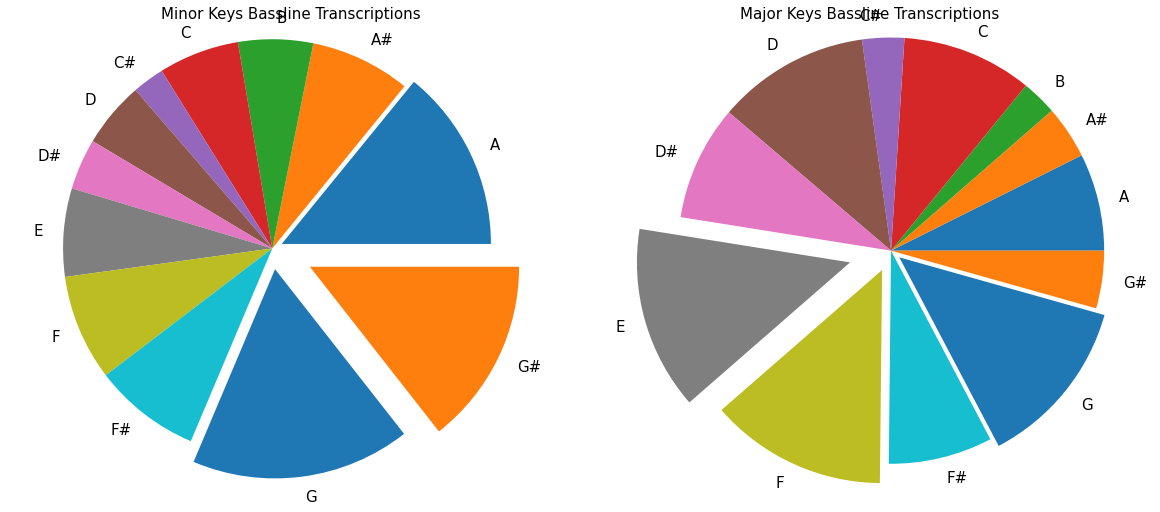

In [98]:
M=8

representation_path = os.path.join('..','data','datasets')
df_minor, df_major = create_dataframes(track_dicts, bad_titles, M, directories,  MAX_NOTE=60, MIN_NOTE=24)

m_counter = count_keys(df_minor, track_dicts)
M_counter = count_keys(df_major, track_dicts)

key_pie_charts(m_counter, M_counter)

## Fix to a Single Octave

In [106]:
titles = df_minor.iloc[:,0].tolist()
X = df_minor.iloc[:,1:].to_numpy()  
np.unique(X)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

MAX_NOTE = 24
X = replace_sustain(X, MAX_NOTE+1)
np.unique(X)

In [107]:
MAX_NOTE = 37
X = replace_sustain(X, MAX_NOTE+1)

print(np.unique(X))
X[X<13] += 12
print(np.unique(X))
X[X>=13+12+12] -= 24
print(np.unique(X))
X[X>=13+12] -= 12
print(np.unique(X))
X -= 12
print(np.unique(X))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37]
[12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36]
[12 13 14 15 16 17 18 19 20 21 22 23 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


# put sustain
X = np.stack([encode_midi_sequence(code, sustain_code=13) for code in X], axis=0)

In [108]:
df_minor_new = pd.DataFrame(X)
df_minor_new['Title'] = titles
df_minor_new = df_minor_new.reindex(columns=['Title'] + [x for x in np.arange(X.shape[1])])

In [109]:
df_minor_new.head()

,Title,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,RAMA7 - Smiling Faces (Original Mix),0,1,1,1,1,8,8,11,0,...,8,11,0,1,1,1,1,8,8,11
1,Mind Body & Soul (Original Mix),0,0,0,0,0,7,0,0,0,...,7,7,7,0,7,8,7,7,7,8
2,All I Need,0,0,0,0,4,0,0,4,4,...,4,4,4,4,0,4,4,4,4,4
3,Eydrian - What Is Your What is Mine (F.Gazza J...,0,2,0,0,0,4,0,2,1,...,0,0,2,2,0,4,0,1,0,4
4,Anatta - Kickback Afterhours (Original Mix),0,0,0,12,12,0,6,1,1,...,6,1,12,6,8,2,2,8,8,8


## provide non-transposed midi sequences (doesn't funtion now) 

note_counter, note_counter_T = count_notes(track_dicts, directories, M)

plot_note_occurances(note_counter, note_counter_T, M)

## Groove Dataset

In [113]:
np.unique(X)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [115]:
X[X!=0] = 1

df_minor_new = pd.DataFrame(X)
df_minor_new['Title'] = titles
df_minor_new = df_minor_new.reindex(columns=['Title'] + [x for x in np.arange(X.shape[1])])

In [116]:
dataset_name = 'TechHouse_bassline_representations_4521'

representation_path = os.path.join('..','data','datasets', 'groove') #'[28, 51]'
os.makedirs(representation_path, exist_ok=True)
min_title = dataset_name+'_min_M{}.csv'.format(M)
min_dir = os.path.join(representation_path, min_title)
df_minor_new.to_csv(min_dir, index=False, header=False)

## Exporting

In [87]:
dataset_name = 'TechHouse_bassline_representations_4020'

representation_path = os.path.join('..','data','datasets', '[28, 51]', 'sus') #'[28, 51]'
os.makedirs(representation_path, exist_ok=True)
min_title = dataset_name+'_min_M{}.csv'.format(M)
min_dir = os.path.join(representation_path, min_title)
df_minor.to_csv(min_dir, index=False, header=False)

dataset_name = 'TechHouse_bassline_representations'

representation_path = os.path.join('..','data','datasets','[28, 51]')

for M in [1, 2, 4, 8]:
    df_minor, df_major = create_dataframes(track_dicts, bad_titles, M, directories)

    min_title = dataset_name+'_min_M{}.csv'.format(M)
    min_dir = os.path.join(representation_path, min_title)
    df_minor.to_csv(min_dir, index=False, header=False)

    maj_title = dataset_name+'_maj_M{}.csv'.format(M)
    maj_dir = os.path.join(representation_path, maj_title)
    df_major.to_csv(maj_dir, index=False, header=False)

# Merging Track Dicts

In [ ]:
directories = get_directories('../data/directories.json')

track_dicts_name = 'traxsource_crawl_0_2500_track_dicts.json'
_, track_dicts0, track_titles0 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_2500_5000_track_dicts.json'
_, track_dicts1, track_titles1 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_5000_7500_track_dicts.json'
_, track_dicts2, track_titles2 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_7500_10000_track_dicts.json'
_, track_dicts3, track_titles3 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'traxsource_crawl_10000_10898_track_dicts.json'
_, track_dicts4, track_titles4 = read_metadata(directories, track_dicts_name)

track_dicts_name = 'TechHouse_track_dicts.json'
_, track_dicts5, track_titles3 = read_metadata(directories, track_dicts_name)

track_dicts = merge_track_dicts(track_dicts0, track_dicts1, track_dicts2, track_dicts3, track_dicts4, track_dicts5)
track_titles = list(track_dicts.keys())

with open('../data/metadata/TechHouse_total_track_dicts.json', 'w') as outfile:
    json.dump(track_dicts, outfile, indent=4)